In [418]:
### connect to the database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
con = sqlite3.connect('atliq_db.sqlite3') #-->specify the path to your 
#downloaded database just like you read csv files

### check all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

### execute simple query in Python with your connection
query="""Select * from 
dim_customer
LIMIT 10
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.head()

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [419]:
#Test if libraries can be access
#con = sqlite3.connect('atliq_db.sqlite3')
#query = "SELECT * FROM dim_product"
#dim_product = pd.read_sql_query(query, con)
#dim_product.head(5)

In [420]:
# Read all the libraries and assign them to names
dim_customer = pd.read_sql_query(query, con)
dim_product = pd.read_sql_query(query, con)
fact_pre_discount = pd.read_sql_query(query, con)
fact_manufacturing_cost = pd.read_sql_query(query, con)
fact_gross_price = pd.read_sql_query(query, con)
fact_sales_monthly = pd.read_sql_query(query, con)

In [421]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

# SQL query to select all columns from the dim_product table
query = "SELECT * FROM fact_gross_price"

# Execute the query and load the result into a DataFrame
fact_gross_price = pd.read_sql_query(query, con)

# Display the DataFrame
display(fact_gross_price.head(5))

# Close the database connection
con.close()

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.40
1,A0118150101,2019,14.44
2,A0118150101,2020,16.23
3,A0118150101,2021,19.06
4,A0118150102,2018,19.59


# 1. Quantity Top sellers

We will gather the top sellers for the month and quarter to see which products were selling the most during times of the year.

In [422]:
con = sqlite3.connect('atliq_db.sqlite3')

# Load the datasets into DataFrames
dim_customer = pd.read_sql_query("SELECT * FROM dim_customer", con)
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_pre_discount = pd.read_sql_query("SELECT * FROM fact_pre_discount", con)
fact_manufacturing_cost = pd.read_sql_query("SELECT * FROM fact_manufacturing_cost", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)

# Close the database connection
con.close()

In [423]:
# Merge fact_sales_monthly with dim_product to get product names
merged_data = pd.merge(fact_sales_monthly, dim_product, how='left', left_on='product_code', right_on='product_code')

In [424]:
# Convert 'date' column to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [425]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')

In [426]:
# Aggregate sales data
monthly_sales = merged_data.groupby(['month_year', 'product'])['sold_quantity'].sum().reset_index()

In [427]:
# Rank the products by sales within each month
monthly_sales['rank'] = monthly_sales.groupby('month_year')['sold_quantity'].rank(method='first', ascending=False)

In [428]:
# Select the top 3 products for each month
top2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

In [429]:
# Convert month_year to string for better visualization
top2_monthly_sales['month_year'] = top2_monthly_sales['month_year'].astype(str)

In [430]:
# Display the results
display(top2_monthly_sales.head(8))

,month_year,product,sold_quantity,rank
1,2017-09,AQ Mforce Gen X,6188.00,1.00
0,2017-09,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,5237.00,2.00
3,2017-10,AQ Mforce Gen X,8388.00,1.00
2,2017-10,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,6472.00,2.00
5,2017-11,AQ Mforce Gen X,11370.00,1.00
4,2017-11,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9642.00,2.00
7,2017-12,AQ Mforce Gen X,12043.00,1.00
6,2017-12,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,9572.00,2.00


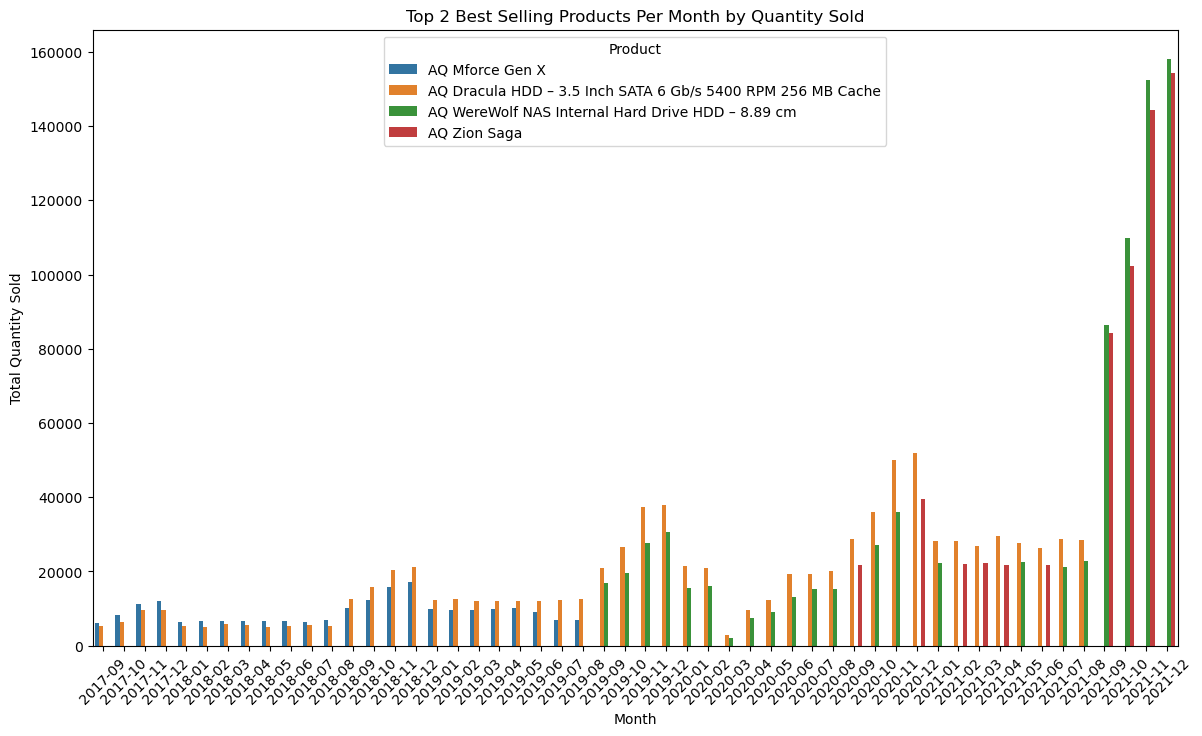

In [431]:
#Create a plot graph to show case how they are always the top sellers
plt.figure(figsize=(14, 8))
sns.barplot(x='month_year', y='sold_quantity', hue='product', data=top2_monthly_sales)
plt.title('Top 2 Best Selling Products Per Month by Quantity Sold')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()

At the beginning of our graph in September of 2017, the "Mforce Gen X" and "Dracula HDD" were the top sellers for a long time until July 2017. After this, the Mforce was replace with "WereWolf NAS HHD". On the other hand, the Dracula HDD was a top seller until July 2021. Three years of being a top seller says something about a product. In august of 2021 Not only sales skyrocketed with the "WereWolf NAS HDD" and "Zion Saga" being the top sellers.

Top Sellers per Quarter

In [432]:
# Merge fact_sales_monthly with dim_product to get product names
merged_data = pd.merge(fact_sales_monthly, dim_product, how='left', left_on='product_code', right_on='product_code')

In [433]:
# Convert 'date' column to datetime if necessary
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [434]:
# Extract year and quarter from the date
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

In [435]:
# Aggregate sales data
quarterly_sales = merged_data.groupby(['year_quarter', 'product'])['sold_quantity'].sum().reset_index()

In [436]:
# Rank the products by sales within each quarter
quarterly_sales['rank'] = quarterly_sales.groupby('year_quarter')['sold_quantity'].rank(method='first', ascending=False)

In [437]:
# Select the top 2 products for each quarter
top2_quarterly_sales = quarterly_sales[quarterly_sales['rank'] <= 2].sort_values(['year_quarter', 'rank'])

In [438]:
# Display the results
display(top2_quarterly_sales.head(6))

,year_quarter,product,sold_quantity,rank
1,2017-Q3,AQ Mforce Gen X,6188.00,1.00
0,2017-Q3,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,5237.00,2.00
3,2017-Q4,AQ Mforce Gen X,31801.00,1.00
2,2017-Q4,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,25686.00,2.00
5,2018-Q1,AQ Mforce Gen X,19856.00,1.00
4,2018-Q1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,16117.00,2.00


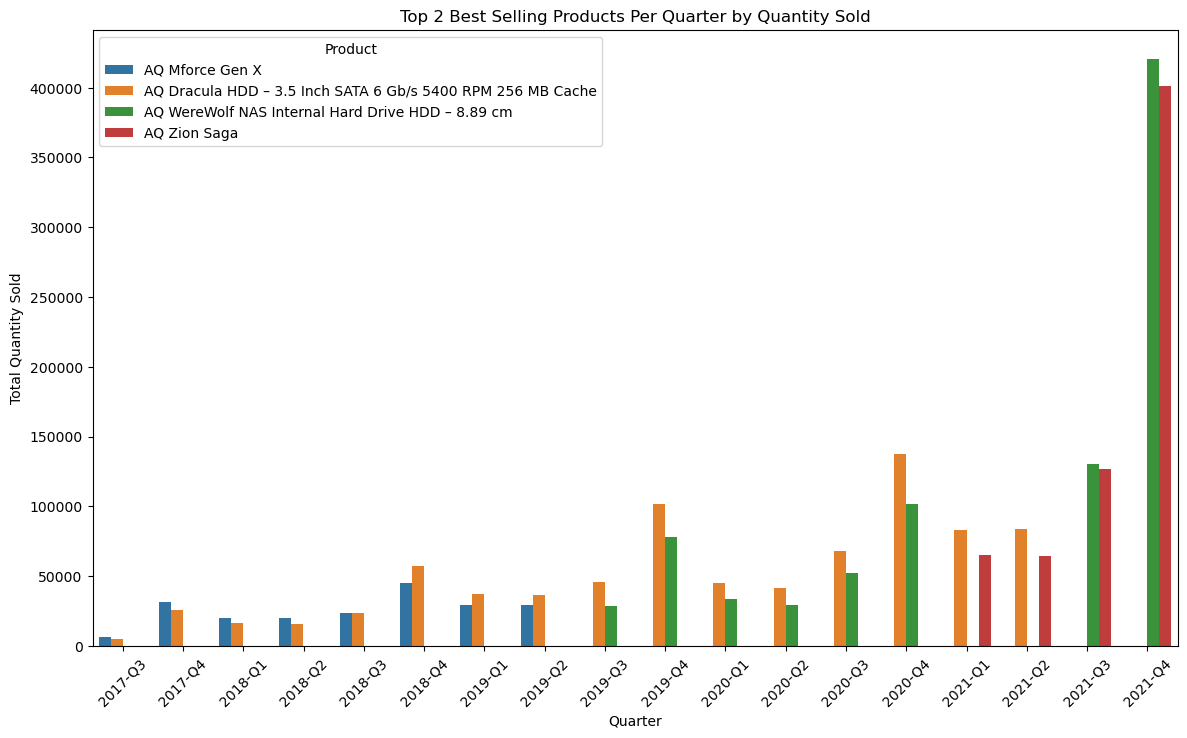

In [439]:
# Plot graph for best sellers per quarter
plt.figure(figsize=(14, 8))
sns.barplot(x='year_quarter', y='sold_quantity', hue='product', data=top2_quarterly_sales)
plt.title('Top 2 Best Selling Products Per Quarter by Quantity Sold')
plt.xlabel('Quarter')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product')
plt.xticks(rotation=45)
plt.show()

Taking a look at the quarterly, we can see how its very similar to the monthly sales, in regards to the top sellers.

### 2. Revenue Top Sellers

We will gather the revenue for each top seller from the previous mentioned per month and quarter.

In [440]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

In [441]:
# Load the datasets into DataFrames
dim_product = pd.read_sql_query("SELECT * FROM dim_product", con)
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)

In [442]:
# Close the database connection
con.close()

In [443]:
# Ensure the date columns are correctly parsed
fact_sales_monthly['date'] = pd.to_datetime(fact_sales_monthly['date'])

In [444]:
# Extract the fiscal year from the date in the sales data
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['date'].dt.year

In [445]:
# Merge fact_sales_monthly with fact_gross_price to get gross price information
merged_sales_price = pd.merge(fact_sales_monthly, fact_gross_price, 
                              how='left', 
                              on=['product_code', 'fiscal_year'])

In [446]:
# Calculate revenue (gross price * sold quantity)
merged_sales_price['revenue'] = merged_sales_price['gross_price'] * merged_sales_price['sold_quantity']

In [447]:
# Merge the result with dim_product to get product names
merged_data = pd.merge(merged_sales_price, dim_product, how='left', left_on='product_code', right_on='product_code')


In [448]:
# Extract month and year from the date
merged_data['month_year'] = merged_data['date'].dt.to_period('M')

In [449]:
# Extract year and quarter from the date
merged_data['year'] = merged_data['date'].dt.year
merged_data['quarter'] = merged_data['date'].dt.quarter
merged_data['year_quarter'] = merged_data['year'].astype(str) + '-Q' + merged_data['quarter'].astype(str)

In [450]:
# Aggregate sales data by month
monthly_sales = merged_data.groupby(['month_year', 'product'])['revenue'].sum().reset_index()

In [451]:
# Rank the products by revenue within each month
monthly_sales['rank'] = monthly_sales.groupby('month_year')['revenue'].rank(method='first', ascending=False)

In [452]:
# Select the top 2 products for each month
top2_monthly_sales = monthly_sales[monthly_sales['rank'] <= 2].sort_values(['month_year', 'rank'])

In [453]:
# Convert month_year to string for better visualization
top2_monthly_sales['month_year'] = top2_monthly_sales['month_year'].astype(str)

In [454]:
# Aggregate sales data by quarter
quarterly_sales = merged_data.groupby(['year_quarter', 'product'])['revenue'].sum().reset_index()

In [455]:
# Rank the products by revenue within each quarter
quarterly_sales['rank'] = quarterly_sales.groupby('year_quarter')['revenue'].rank(method='first', ascending=False)

In [456]:
# Select the top 2 products for each quarter
top2_quarterly_sales = quarterly_sales[quarterly_sales['rank'] <= 2].sort_values(['year_quarter', 'rank'])

In [457]:
# Display the results
display(top2_monthly_sales.sample(4))
display(top2_quarterly_sales.sample(4))

,month_year,product,revenue,rank
78,2020-01,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,364865.56,2.00
52,2019-06,AQ Mforce Gen X,141360.00,2.00
66,2019-10,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,257939.86,2.00
56,2019-07,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,122492.62,2.00


,year_quarter,product,revenue,rank
11,2018-Q4,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,1060920.20,1.00
14,2019-Q1,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,655357.88,1.00
47,2021-Q1,AQ Zion Saga,1708644.26,2.00
34,2020-Q2,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,693046.14,2.00


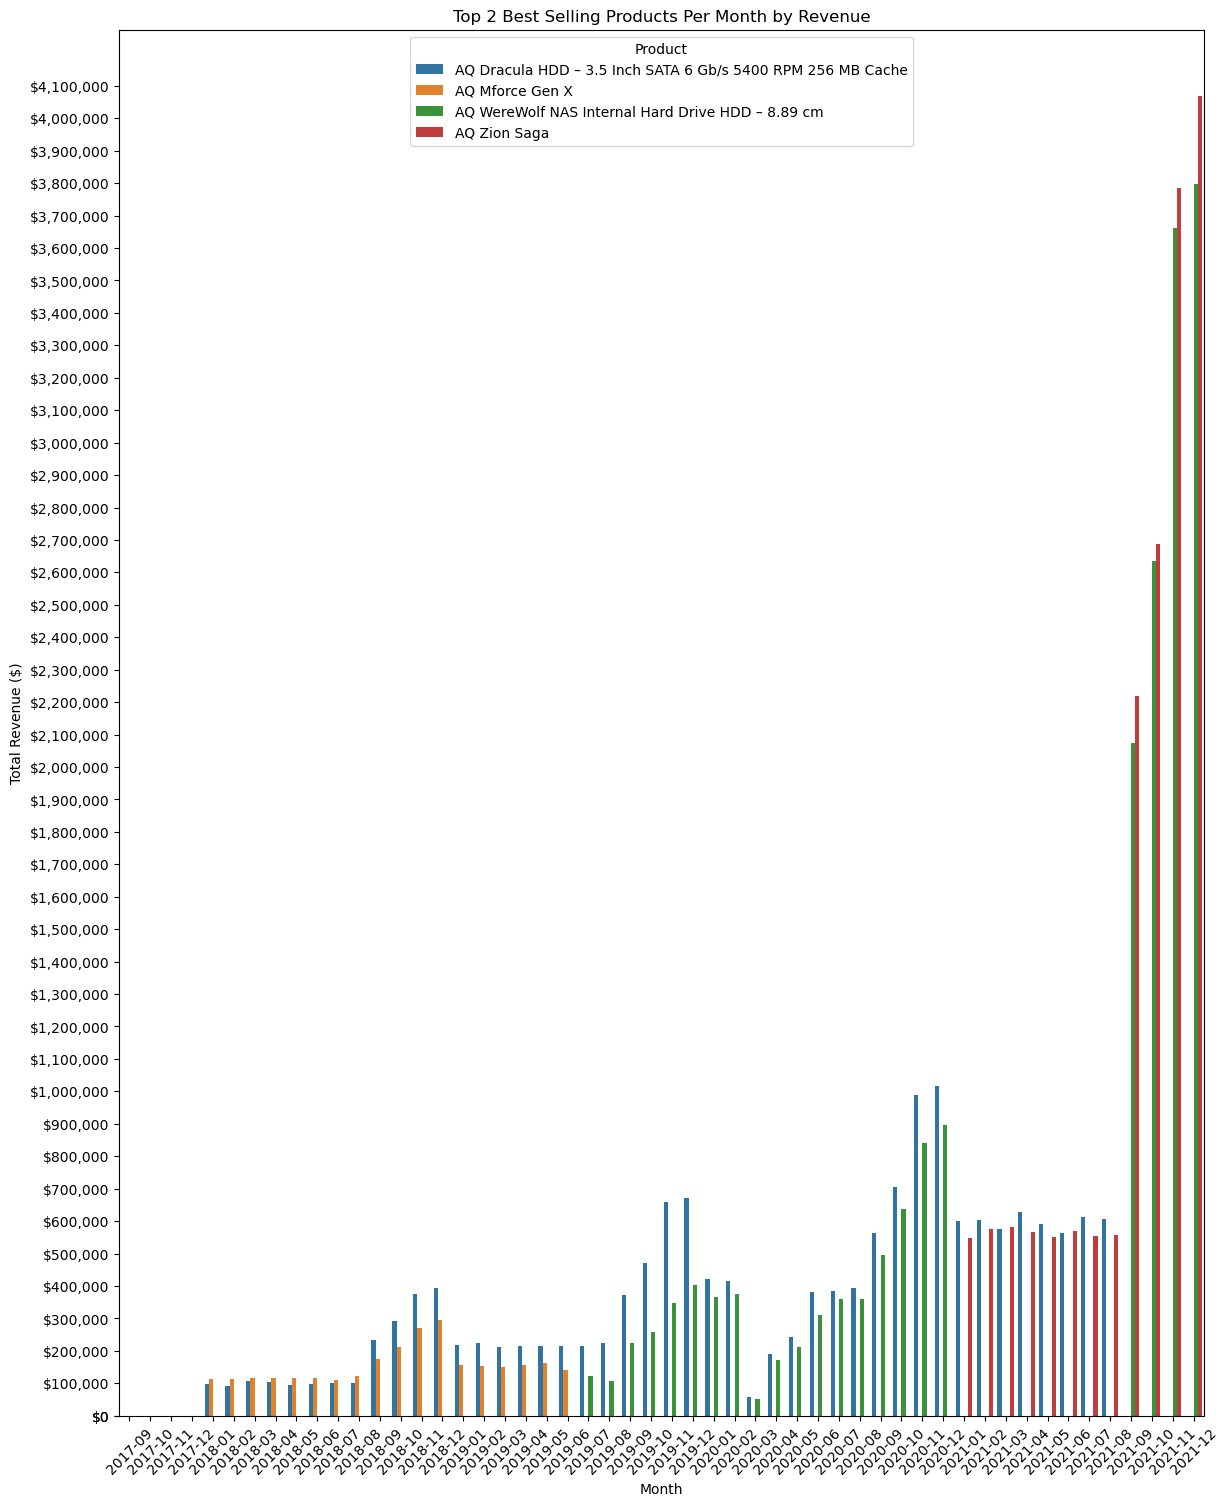

In [458]:
# Visualization for monthly top sellers by revenue
plt.figure(figsize=(14, 18))
sns.barplot(x='month_year', y='revenue', hue='product', data=top2_monthly_sales)
plt.title('Top 2 Best Selling Products Per Month by Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)

# Custom ticks for Y-axis
max_revenue_first_3_months = top2_monthly_sales[top2_monthly_sales['month_year'].isin(top2_monthly_sales['month_year'].unique()[:3])]['revenue'].max()
ticks_first_3_months = np.arange(0, max_revenue_first_3_months + 10000, 10000)
ticks_rest = np.arange(max_revenue_first_3_months, top2_monthly_sales['revenue'].max() + 100000, 100000)
custom_ticks = np.concatenate([ticks_first_3_months, ticks_rest])
custom_labels = ['${:,.0f}'.format(x) for x in custom_ticks]
plt.yticks(ticks=custom_ticks, labels=custom_labels)

plt.show()

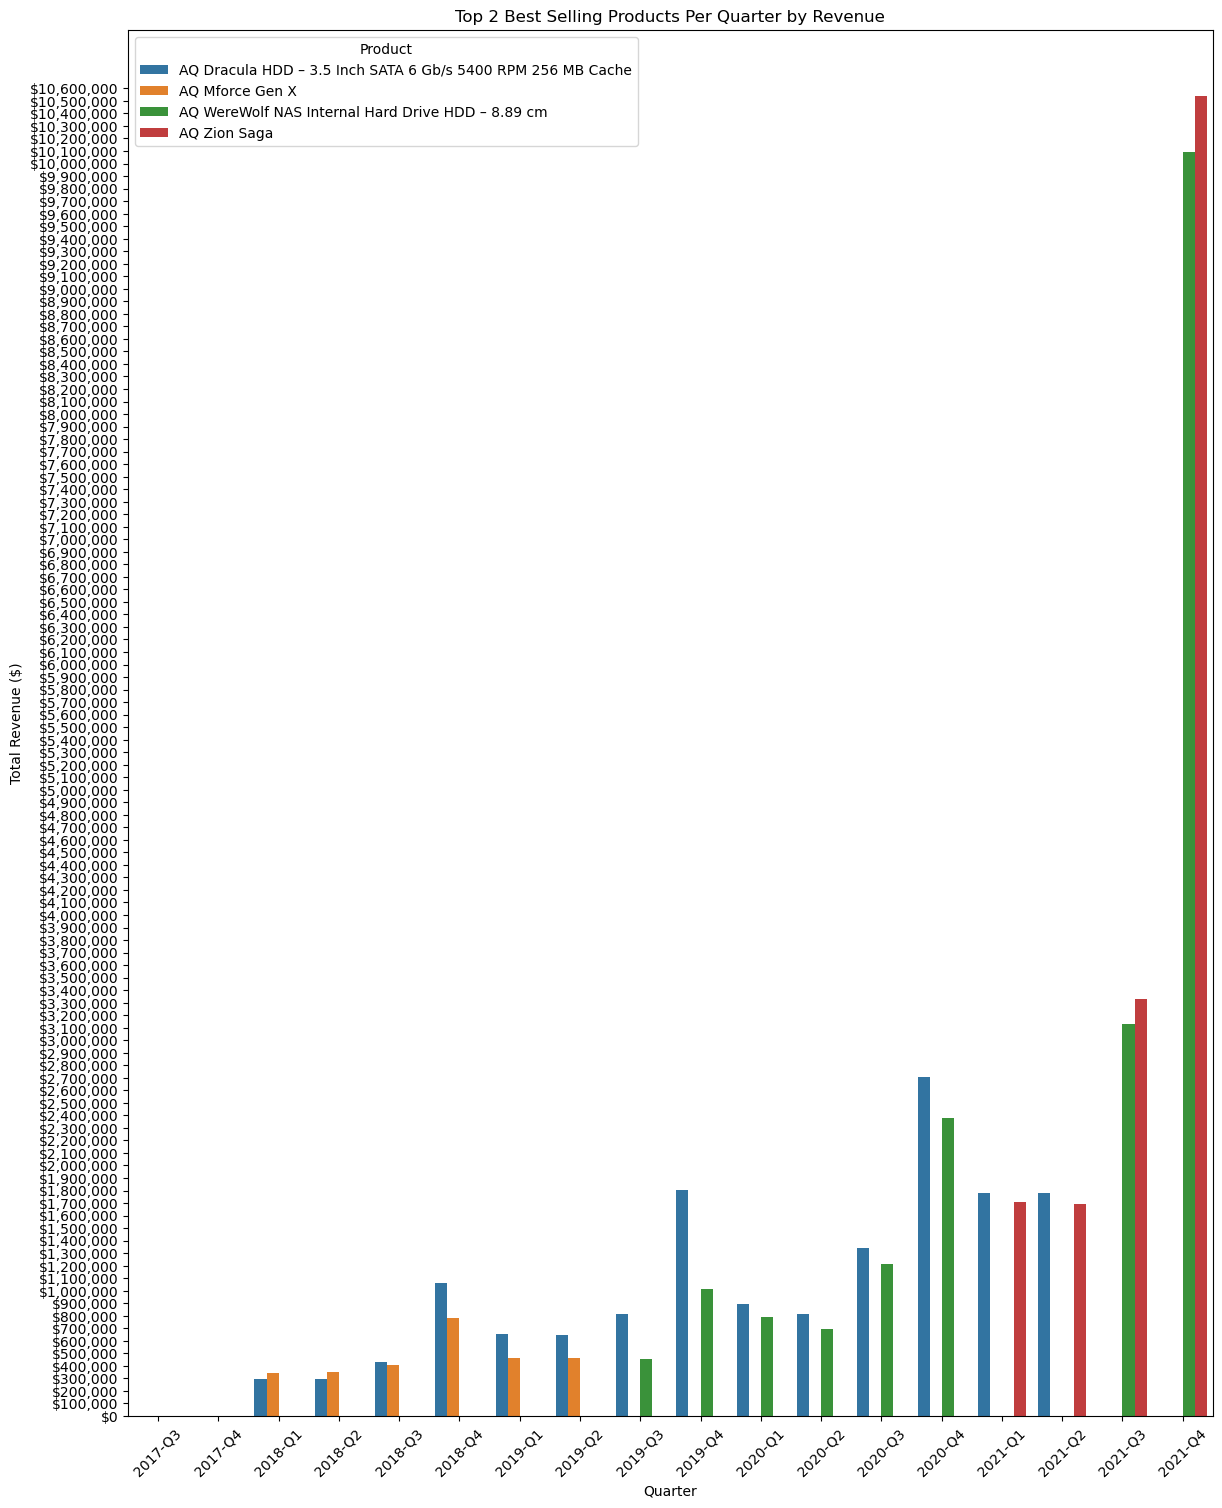

In [459]:
# Visualization for quarterly top sellers by revenue
plt.figure(figsize=(14, 18))
sns.barplot(x='year_quarter', y='revenue', hue='product', data=top2_quarterly_sales)
plt.title('Top 2 Best Selling Products Per Quarter by Revenue')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Product')
plt.xticks(rotation=45)

# Custom ticks for Y-axis for quarterly data
max_revenue_quarter = top2_quarterly_sales['revenue'].max()
ticks_quarter = np.arange(0, max_revenue_quarter + 100000, 100000)
custom_labels_quarter = ['${:,.0f}'.format(x) for x in ticks_quarter]
plt.yticks(ticks=ticks_quarter, labels=custom_labels_quarter)

plt.show()